In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import scipy.stats as stats
import math
import sklearn.preprocessing

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# train test split from sklearn
from sklearn.model_selection import train_test_split
# imputer from sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import acquire 
import explore as e
import wrangle as w
import regression_models as m
a = .05

# Acquire

* I acquired this data from the Codeup database using mySQL workbench
* Each observation or row provides a value or description of a home
* Each column represents a feature of the property
* I acquired this data on Wednesday November 15th 

# Prepare

* Removed null values with query from mySQL and single family property specifications
* Split data into train, validate and test(approx. 50/30/20)
* Based on data from United States Census bureau limited home square footage to 2,500
* Converted fips numeric value to string value 
* Encoded Fips location strings into ones and zeros
* Renamed multiple columns : bedrooms, bathrooms, complete square footage 

 

## Data Dictionary
| Feature | Definition |
|:--------|:-----------|
|Beds| Number of bedrooms in the home|
|Baths| Number of bathrooms in the home|
|sqft| The square footage of the home|
|rooms count| Represents the total number of rooms in the home|
|fips| The county the property is located in Los Angelese County CA, Ventura CA or Orange County CA|

In [2]:
#create, train, validate, test datasets
train, validate, test = w.wrangle_zillow()

### Takeaways

- The median property value is 316,213
- The mean property value is 376,063
- The difference between these values is 59,850

# Exploration of Data

### What is the median and mean home price? 

In [3]:
# Mean compared to Median 
e.statistic_table(train)

Metric         Value
----------  --------
Median      316213
Mean        376063
Difference   59850.4


### Takeaways

- The median property value is 316,213
- The mean property value is 376,063
- The difference between these values is 59,850

# Statistical Questions Section

### Is there a significant difference in mean property value across Los Angeles, Ventura County and Orange County?  

In [4]:
# Count of properties in each County
e.value_counts(train)

Los Angeles CA       15825
Orange County CA      5701
Ventura County CA     1851
Name: fips, dtype: int64

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


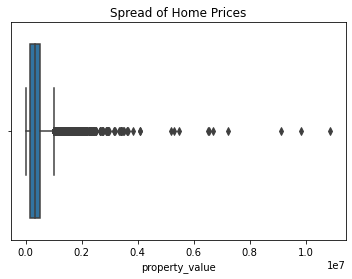

In [7]:
# creates boxplot of property values
e.boxplot(train,"property_value", "Spread of Home Prices")

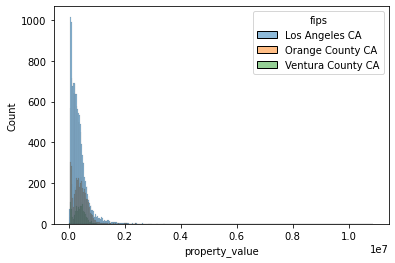

In [8]:
# creates histogram of properties in counties
e.hists(train)

### Chart Takeaways 
- 5x as many homes in los angeles compared to Orange County in train sample
- 15x as many homes in Los Angeles compared to Ventura County
- Los Angeles has widest spread of property values due to it's outliers
- There appears to be a higher frequency of homes being sold in Los Angeles compared to the other counties
- Do prices on average have a higher value in Los Angeles compared to the other two counties


### Hypothesis

- Ho: There is no difference in mean property values across Los Angeles County, Ventura County and Orange County<br>
- Ha: There is a significant difference in mean property values across Los Angeles County, Ventura County and Orange County

In [9]:
# generating variance for each county's property values
e.variances(train)

Los Angeles County Property Value Variance = 137423766689.9801
Orange County Property Value Variance = 85736846687.3435
Ventura County Property Value Variance = 40991959968.3378


In [10]:
# results of statistical test 
e.stats_property_location(train)

Kruska Result = 601.2471
p = 2.7595841708077645e-131


### Takeaways 
- These prices are not normally distributed 
- Use Kruskal-Wallis test since prices not normally distributed 
- Variances are not similar 
- There is a significant difference in the mean property value of the homes across Los Angeles, Ventura and Orange County 


### Is there a correlation between square footage and property value?  

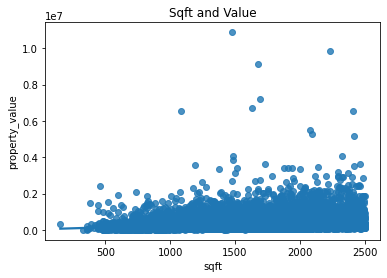

In [11]:
#visualization of sqft vs property value 
e.scatter_plot(train)

### Chart Takeaways 
- As home square footage increases there are more outliers in property value

### Hypothesis: 

**Ho: There is no correlation between home square footage and property value.**<br>
**Ha: There is a correlation between home square footage and property value.** 

In [12]:
# Statistc test results
e.correlation_stat_test(train,'sqft')

Correlation Strength = 0.2865
p = 0.0


### Takeaways
- Test is significant and there is a weak positive correlation between home sqft and home price

### Is there a correlation between the bedrooms  and property value ?  

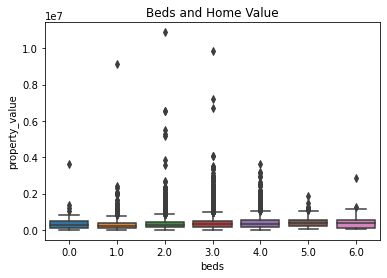

In [13]:
# box plot Bedrooms vs Property value 
e.two_variable_boxplots(train,'beds','property_value','Beds and Home Value')

### Takeaways 

- Most outliers are seen between two and three bedroom homes 
- Across bedrooms there does not appear to be a major difference in their interquartile range

### Hypothesis: 

**Ho: There is no correlation between number of beds and property value.**<br>
**Ha: There is a correlation between number of beds and property value.** 


In [14]:
# Statistical test results 
e.correlation_stat_test(train,'beds')

Correlation Strength = 0.0501
p = 1.86139227403694e-14


### Takeaways 
- Bedrooms has a weak positive correlation to the property value 

### Is there a correlation between the bathrooms  and property value ?  

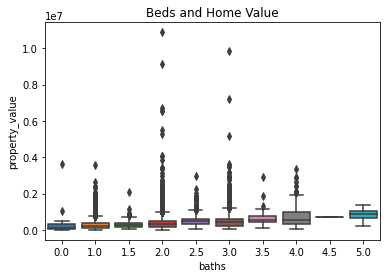

In [15]:
# box plot Bathrooms vs Property value 
e.two_variable_boxplots(train,'baths','property_value','Beds and Home Value')

### Hypothesis: 

**Ho: There is no correlation between number of baths and property value.**<br>
**Ha: There is a correlation between number of baths and property value.** 


In [16]:
# Statistical test results 
e.correlation_stat_test(train,'baths')

Correlation Strength = 0.2264
p = 1.9051176926278047e-269


### Takeaways

- There is a weak positive correlation between bathrooms and property value
- There are slight differences in the interquartile ranges of the different bathroom counts

### Is there a correlation between the room count and property value ?  

In [17]:
# Create rooms count column in train dataframe
e.rooms_count(train)

,index,beds,baths,fips,sqft,property_value,fips_Orange County CA,fips_Ventura County CA,rooms_count
0,40577,3.0,2.0,Los Angeles CA,1290.0,443206.0,0,0,5.0
1,31790,3.0,1.0,Los Angeles CA,1441.0,446001.0,0,0,4.0
2,28080,2.0,1.0,Los Angeles CA,1259.0,130785.0,0,0,3.0
3,21919,4.0,3.0,Orange County CA,1859.0,349142.0,1,0,7.0
4,16197,2.0,1.0,Los Angeles CA,1020.0,283500.0,0,0,3.0
...,...,...,...,...,...,...,...,...,...
23372,18392,1.0,1.0,Los Angeles CA,672.0,352080.0,0,0,2.0
23373,7039,3.0,2.0,Orange County CA,1243.0,413682.0,1,0,5.0
23374,14668,3.0,2.0,Los Angeles CA,1100.0,261693.0,0,0,5.0
23375,20664,4.0,2.0,Los Angeles CA,1924.0,96352.0,0,0,6.0


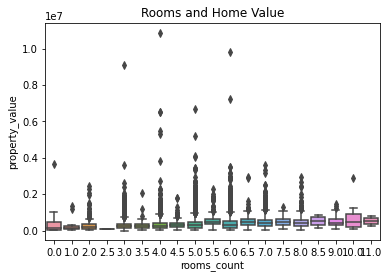

In [18]:
# box plot Rooms vs Property value 
e.two_variable_boxplots(train,'rooms_count','property_value','Rooms and Home Value')

### Takeaways

- From 3 rooms to 6 rooms there is a wide range of price covered due to outliers 
- There is a consistent postive trend in max price as the room counts increase from 1 to 7

### Hypothesis

**Ho: There is no correlation between number of rooms and property value.**<br>
**Ha: There is a correlation between number of rooms and property value.** 

In [19]:
# Statistical test results 
e.correlation_stat_test(train,'rooms_count')

Correlation Strength = 0.1481
p = 1.1278788485136645e-114


### Takeaways
- there is a weak positive correlation between total rooms in a home and property value

## Exploration Summary

* Median price is x
* Mean property value is x
* The difference between Mean and Median is 147,254
* The features used for modeling will be baths, beds, sqft
* The statistical tests provide support that there is a correlation between Property value and baths, beds, sqft
* Statistical testing supports a significant relationship between fips code and property value 


## Features included in Models

* The features for my models are baths and sqft
* These features showed the strongest correlations with property value in my statistical tests 

## Features NOT included in Model

* Rooms count, bedrooms and fips will not be included in my Model
* The results of these statistical tests were significant but the strength was not as strong as the two variables I chose

## Setting up train, validate and test variables 

## Scale data for X train

In [20]:
# columns used as independent variables 
x_cols = ['baths','sqft']

In [21]:
# assigning features to x/y train, validate and test 
X_train = train[x_cols]
y_train = train['property_value']

X_validate = validate[x_cols]
y_validate = validate['property_value']

X_test = test[x_cols]
y_test = test['property_value']

In [22]:
# applying scaling to all the data splits.
scaler = sklearn.preprocessing.RobustScaler()
scaler.fit(X_train)

# transforming train, validate and test datasets
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)



# Modeling

### Introduction

* I will use Root Mean Squared error as my evaluation metric
* The median property value is 316,213
* The mean property value is 376,063
* My baseline model is created from the Root Mean Squared error (RMSE) of the median property value of the train and validate data set
* Models will be evaluated on train and validate data sets 
* The model that performs the best will be evaluated on the test data

In [23]:
# prepare data for models
X_train, X_validate, y_train, y_validate, X_test, y_test = m.model_columns(train,validate,test)

In [24]:
# Scale features
m.scaling(X_train,X_validate,X_test)

## Baseline Model

In [26]:
# creating baseline model
m.baseline_model(y_train,y_validate)

RMSE using Median
Train/In-Sample:  348486.33 
Validate/Out-of-Sample:  322222.84


## LinearRegression OLS 

In [28]:
m.linearOLS(X_train,X_validate,y_train,y_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  328794.5390412238 
Validation/Out-of-Sample:  301983.58413777215


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [29]:
# Comparing performance to baseline 

print(((rmse_linearreg_train-rmse_train)/rmse_train)*100)


NameError: name 'rmse_linearreg_train' is not defined

### Takeaways 
- model performs better than baseline 
- Reduces amount of explained error by almost 6% 

## LassoLars 

In [30]:
m.lassolars(X_train,X_validate, y_train,y_validate)

RMSE for Lasso + Lars
Training/In-Sample:  328794.5801734886 
Validation/Out-of-Sample:  301982.20921809884


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [ ]:
print(((rmse_laso_lars_train-rmse_train)/rmse_train)*100)

### Takeaways 
- model performs better than baseline 
- Reduces amount of explained error by almost 6% 

## TweedieRegressor(GLM) 

In [31]:
m.tweedie(X_train,X_validate,y_train,y_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  343308.39434088784 
Validation/Out-of-Sample:  316895.4401706822


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/sta

In [ ]:
print(((rmse_tweedie_train-rmse_train)/rmse_train)*100)

## Takeaways
- performs better than baseline 
- Reduces amount of explained error by 1.4%

In [32]:
m.linear_reg(X_train,X_validate,y_train,y_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  327904.65839553217 
Validation/Out-of-Sample:  301231.5140785066


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [ ]:
print(((rmse_linear_train-rmse_train)/rmse_train)*100)

## Takeaways
- performs better than baseline 
- Reduces amount of explained error by almost 6%

## Best Model

### Linear Regression Model is best 

## Test Model
* I will run my Linear regression model on my test data

### Modeling Wrap 

* I would recommend this model for production because it does not over fit the data and it performs 4% better than the baseline

## Conclusion

### Summary
* The median property value is 316,213
* Statistical evidence supports correlations between property value and bedrooms, bathrooms and square feet of a home
* My model uses bathrooms and home square footage to determine home value
* There were very weak correlations between property value and bedrooms and total rooms in a home.  


### Modeling Summary 
* The final model performed approximately 6% better than the baseline
* I would recommend this model for production because it does not over fit the data and and performed better than baseline


### Recommendations
* Solicit for quantitative and qualitative data on why customer's select month to month contracts 
* Review incentives offered for each contract type

### Next Steps
* The next steps of this project would be to take more time to focus on statistically testing the features related to property location
* Review the data to determine if there are a similar amount of transactions across the three counties or if significantly more transactions occur in Los Angeles 